## Building an Open Images classifier dataset

In this notebook we will transform the metadata and image files that we have into a dataset file formatted for input into a machine learning model.

### Prelude

At this point we've already run the script that selected relevant images and and placed them in the `../data/images/` directory. 

In [1]:
%ls ../data/images/ | head

10006714784_9337d5d0e1_o.jpg
10014143174_1de79c8af8_o.jpg
10022662923_ab0567fe1a_o.jpg
10052146336_dc364e0a10_o.jpg
1006312339_d306fc933d_o.jpg
10065094283_0db2b64b2d_o.jpg
10102600246_6385283711_o.jpg
10123662565_4ab592b952_o.jpg
101266618_99a28a70ff_o.jpg
10148587244_f576b88c8f_o.jpg


To do that, we either executed `src/openimager.py` as a script (e.g. `python openimager.py "sandwich" "hot dog" "hamburger"`) or used it as a module (using `openimager.download`). TODO: adapt `download` with a folder target parameter.

### Quick inspection

Let's peak at some example images from the dataset.

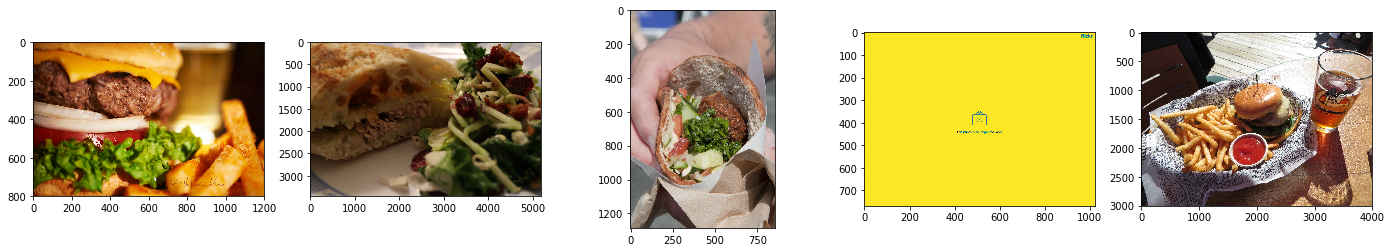

In [10]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import os

fig, axarr = plt.subplots(1, 5, figsize=(24, 4))
for i, img in enumerate(os.listdir('../data/images/')[:5]):
    axarr[i].imshow(imread('../data/images/' + img))

### Packaging the data

However, before we can move on to actually training the model, we must subselect the relevant image metadata, and package that up alongside the raw images so that we have a common starting point.

The script we wrote for downloading relevant training images does all of the work required, but doesn't save that anywhere because it is solely responsible for downloading images, not for saving metadata to disc.

The following segment of code is copied from that routine, and it recreates the relevant metadata.

TODO: unify the script and this code cell with a common method for doing this work.

In [11]:
import pandas as pd

categories = ['Sandwich', 'Hamburger']

kwargs = {'header': None, 'names': ['LabelID', 'LabelName']}
class_names = pd.read_csv("../data/metadata/image-class-names.csv", **kwargs)
train_boxed = pd.read_csv("../data/metadata/train-annotations-bbox.csv", index_col=0)
image_ids = pd.read_csv("../data/metadata/train-images-ids.csv", index_col=0)
label_map = dict(class_names.set_index('LabelName').loc[categories, 'LabelID']
                 .to_frame().reset_index().set_index('LabelID')['LabelName'])
label_values = set(label_map.keys())
relevant_training_images = train_boxed[train_boxed.LabelName.isin(label_values)]
relevant_flickr_urls = (relevant_training_images.set_index('ImageID')
                        .join(image_ids.set_index('ImageID'))
                        .loc[:, 'OriginalURL'])
relevant_flickr_img_metadata = (relevant_training_images.set_index('ImageID').loc[relevant_flickr_urls.index]
                                .pipe(lambda df: df.assign(LabelValue=df.LabelName.map(lambda v: label_map[v]))))

/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Now we join this information in a way that lets us map image to metadata entry.

In [12]:
u_relevant_flickr_urls = pd.Series(relevant_flickr_urls.unique(), 
                                   index=relevant_flickr_urls.index.unique(),
                                   name='OriginalURL')

X_meta = (relevant_training_images
          .set_index('ImageID')
          .join(u_relevant_flickr_urls.map(lambda v: v.split("/")[-1]), how='left')
          .reset_index()
          .pipe(lambda df: df.assign(LabelName=df.LabelName.map(lambda l: label_map[l]))))

In [13]:
X_meta.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,OriginalURL
0,000cd56bb02e4edb,xclick,Hamburger,1,0.158125,0.675000,0.343333,0.795833,1,0,0,1,0,4675526831_1ca7e5a5d8_o.jpg
1,000fcf404455b8dc,xclick,Sandwich,1,0.312500,0.648438,0.595833,0.818750,1,0,0,0,0,5359346138_667b9a0fd8_o.jpg
2,0011e5d4c30a5b42,xclick,Hamburger,1,0.000000,0.999375,0.000000,0.981667,1,1,0,0,0,2236254570_4055805e8d_o.jpg
3,0012119430478f5a,xclick,Hamburger,1,0.531875,0.936875,0.000000,0.648421,1,1,0,0,0,4918549508_52fc91fc58_o.jpg
4,001ac70b6184abed,xclick,Hamburger,1,0.166250,0.357500,0.450833,0.697500,0,0,0,0,0,400114846_1d888f39f5_o.jpg


The dataset includes images which have been deleted, which are replaced with a placeholder image by the Flickr service. We can only detect that an image has been deleted by inspecting how many channels we see when we read the image in. One channel means grayscale, which in turn means the image is a placeholder.

In [14]:
import numpy as np
from PIL import Image  # pip install pillow
from tqdm import tqdm_notebook

def get_image_arr(img):
    """Given an image URL, returns that image read out from local disk into a numpy array."""
    return np.asarray(Image.open('../data/images/' + img))

def is_non_unary_channel(img_arr):
    """Returns whether or not the given image has multiple channels or not (expect 3: RGB)."""
    return len(img_arr.shape) == 3 and img_arr.shape[2] > 1


is_non_unary = []
for idx, srs in tqdm_notebook(list(X_meta.iterrows())):
    is_non_unary.append(is_non_unary_channel(get_image_arr(srs.OriginalURL)))

/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 285413634 bytes but only got 0. Skipping tag 780
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1239089152 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1238564864 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10485760 bytes but only got 0. Skipping tag 3
  " 

In [15]:
X_meta = X_meta[is_non_unary]

The machine learning model takes the raw images as input. In order for that to work, the input images must all be the same size. The boxed images included in this dataset are _not_ all the same size (or orientation, or anything else like that). They are in this way representative of true image classification task out "in the wild", as opposed to more templatized image recognition tasks like MNIST and Fashion-MNIST.

In [16]:
import matplotlib.pyplot as plt

def get_bounds(img_arr, srs):
    img_xmax, img_ymax = img_arr.shape[1], img_arr.shape[0]
    bbox_x_min, bbox_x_max = srs.XMax * img_xmax, srs.XMin * img_xmax
    bbox_y_min ,bbox_y_max = srs.YMax * img_ymax, srs.YMin * img_ymax
    return bbox_x_max, bbox_x_min, bbox_y_max, bbox_y_min

def get_bbox_points(bounds):
    return [[bounds[0], bounds[0], bounds[1], bounds[1], bounds[0]], 
            [bounds[2], bounds[3], bounds[3], bounds[2], bounds[2]]]

Test to make sure we have the right bounding box extraction code:

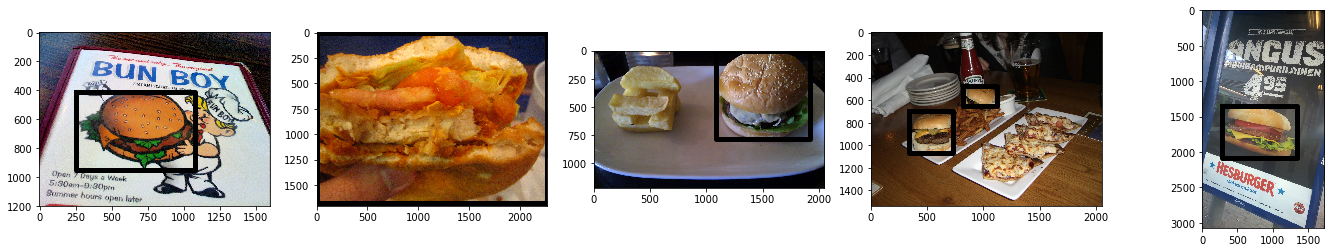

In [39]:
fig, axarr = plt.subplots(1, 5, figsize=(24, 4))
kwargs = {'color': 'black', 'linewidth': 5}

axarr[0].imshow(np.asarray(Image.open('../data/images/' + X_meta.iloc[0].OriginalURL)))
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/images/' + X_meta.iloc[0].OriginalURL)), X_meta.iloc[0])
    ),
    **kwargs
)

axarr[1].imshow(np.asarray(Image.open('../data/images/' + X_meta.iloc[1].OriginalURL)))
axarr[1].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/images/' + X_meta.iloc[1].OriginalURL)), X_meta.iloc[1])
    ),
    **kwargs
)

axarr[2].imshow(np.asarray(Image.open('../data/images/' + X_meta.iloc[2].OriginalURL)))
axarr[2].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/images/' + X_meta.iloc[2].OriginalURL)), X_meta.iloc[2])
    ),
    **kwargs
)

axarr[3].imshow(np.asarray(Image.open('../data/images/' + X_meta.iloc[3].OriginalURL)))
axarr[3].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/images/' + X_meta.iloc[3].OriginalURL)), X_meta.iloc[3])
    ),
    **kwargs
)
axarr[3].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/images/' + X_meta.iloc[4].OriginalURL)), X_meta.iloc[4])
    ),
    **kwargs
)

# skip the hot dog

axarr[4].imshow(np.asarray(Image.open('../data/images/' + X_meta.iloc[7].OriginalURL)))
axarr[4].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/images/' + X_meta.iloc[7].OriginalURL)), X_meta.iloc[7])
    ),
    **kwargs
)

In [14]:
from skimage.transform import resize

def get_cropped_image_arr(img, idx):
    """Given an image URL, returns that image cropped read out from local disk into a numpy array."""
    return np.asarray(Image.open('../data/images/' + img.split('.')[0] + '_' + str(idx) + '.jpg'))   

def crop_image_to_bbox(img_arr, X_meta_srs):
    """Given an image array, crops the image to just the bounding box provided."""
    shape = img_arr.shape
    x_min, x_max, y_min, y_max = get_bounds(img_arr, X_meta_srs)
    x_min, x_max = int(np.floor(x_min)), int(np.ceil(x_max))
    y_min, y_max = int(np.floor(y_min)), int(np.ceil(y_max))
    return img_arr[y_min:y_max, x_min:x_max]

def resize_img_arr(img_arr):
    """Given an image array, resizes that image to a standard size (aspect ratio is not preserved)."""
    return resize(img_arr, (128, 128), anti_aliasing=True, mode='constant', preserve_range=True)

Check that the bounding algorithm is correct.

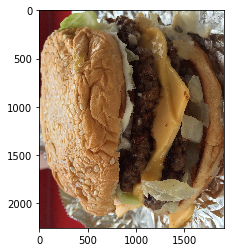

In [15]:
plt.imshow(
    crop_image_to_bbox(get_image_arr(X_meta.iloc[105].OriginalURL), X_meta.iloc[105])
)

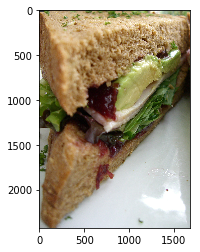

In [16]:
plt.imshow(
    crop_image_to_bbox(get_image_arr(X_meta.iloc[707].OriginalURL), X_meta.iloc[707])
)

In [17]:
def generate_cropped_images(X_meta):
    return (X_meta
     # use the metadata to select images and generate cropped numpy arrays
     .pipe(lambda df: 
           df.apply(
               lambda srs: crop_image_to_bbox(
                   get_image_arr(srs.OriginalURL),
                   srs
               ), axis='columns')
      ))

def save_cropped_images_to_disk(img_arrs, img_meta_df):
    for (img_arr, (idx, img_meta_srs)) in zip(img_arrs, img_meta_df.iterrows()):
        # exclude single-channel (e.g. grayscale) images; these are always be Image Not Found placeholders        
        Image.fromarray(img_arr).save(
            '../data/images_cropped/' + img_meta_srs.LabelName.replace(" ", "_") + "/" +
            img_meta_srs.OriginalURL.split(".")[0] + "_" + str(idx) + ".jpg"
        )

In [18]:
!mkdir ../data/images_cropped
!mkdir ../data/images_cropped/Hamburger
!mkdir ../data/images_cropped/Sandwich

In [19]:
from tqdm import tqdm_notebook

# this process is chunked b/c reading entire images into numpy arrays is very expensive
# you'll run out of memory very easiy because some of the images are very very large
for i in tqdm_notebook(range(X_meta.index.max() // 20 + 1)):
    n_s, n_e = i * 20, i * 20 + 20
    X_meta_fragment = X_meta.iloc[n_s:n_e]
    cropped_imgs = generate_cropped_images(X_meta_fragment)
    save_cropped_images_to_disk(cropped_imgs, X_meta_fragment)

/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 285413634 bytes but only got 0. Skipping tag 780
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1239089152 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1238564864 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/quilt-open-images-dev/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10485760 bytes but only got 0. Skipping tag 3
  " 

In [20]:
X_meta = X_meta.assign(
    ImageCropURL=X_meta.apply(
        lambda srs: srs.OriginalURL.split(".")[0] + "_" + str(srs.name) + ".jpg", axis='columns'
    )
)

In [21]:
X_meta.to_csv("../data/training/X_meta.csv", index=False)